In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

In [7]:
# Cargar Datos y Modelos 
# Cargar el dataset final con todas las features
data_path = "../data/processed/final_dataset.csv"
if not os.path.exists(data_path):
    print(f"Error: El archivo {data_path} no se encuentra. Asegúrate de correr 02_FeatureEngineering.ipynb")
    # Puedes añadir un sys.exit() o manejar el error como prefieras
else:
    df = pd.read_csv(data_path, parse_dates=["first_session"])

# Cargar los MEJORES modelos (los seleccionados mediante TimeSeriesSplit CV)
model_folder = "../models/"
ltv_model_path = os.path.join(model_folder, "LTV_180_best_tscv.pkl")
cac_model_path = os.path.join(model_folder, "CAC_source_30_best_tscv.pkl")

if not os.path.exists(ltv_model_path) or not os.path.exists(cac_model_path):
    print(f"Error: Los modelos .pkl no se encuentran en {model_folder}. Asegúrate de correr Final_Project_Showz_LTV_CAC.ipynb")
    # Manejar el error
else:
    best_ltv_model = joblib.load(ltv_model_path)
    display(best_ltv_model)
    best_cac_model = joblib.load(cac_model_path)
    display(best_cac_model)
    print("Modelos predictivos cargados.")

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['n_sessions',
                                                   'avg_session_duration',
                                                   'session_duration_std',
                                                   'n_orders', 'revenue_total',
                                                   'avg_order_value',
                                                   'conversion_delay_days',
                                                   'order_span_days',
                                                   'orders_per_session',
                                                   'avg_days_between_orde...
                                                   'session_hour',
                                                   'conversion_weekday',
                                                   'source_id',
                                                   'source_conversion_rate',
                                                   'avg_cost_per_user']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['is_churned',
                                                   'is_weekend_session',
                                                   'device'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=400,
                                           random_state=42))])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['n_sessions',
                                                   'avg_session_duration',
                                                   'session_duration_std',
                                                   'n_orders', 'revenue_total',
                                                   'avg_order_value',
                                                   'conversion_delay_days',
                                                   'order_span_days',
                                                   'orders_per_session',
                                                   'avg_days_between_orde...
                                                   'conversion_weekday',
                                                   'source_id',
                                                   'source_conversion_rate',
                                                   'avg_cost_per_user']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['is_churned',
                                                   'is_weekend_session',
                                                   'device'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=4,
                                           n_estimators=200,
                                           random_state=42))])

Modelos predictivos cargados.


In [8]:

# Preparar Datos para Predicción
feature_cols = df.drop(
    columns=['uid', 'first_session', 'last_session',
             'first_order', 'last_order', 'LTV_180', 
             'CAC_source_30', 'ltv_cohort_avg', 
             'cac_cohort_avg', 'conversion_rate_cohort'],
    errors='ignore' # Ignora si alguna columna ya fue eliminada
).columns.tolist()

# Seleccionar solo las columnas de features
X_features = df[feature_cols]

# Verificar que las columnas coincidan con las esperadas por los pipelines (importante!)
print(f"Número de features para predicción: {X_features.shape[1]}")

Número de features para predicción: 23


Predicciones de LTV y CAC generadas.

Valores promedio de ROMI PREDICTED por source_id:
   source_id  predicted_romi_avg
0          1           -0.951968
1          2           -0.998708
2          3           -0.999573
3          4           -0.999290
4          5           -0.999175
5          6           -0.999200
6          7           -0.999251
7          9            3.665258
8         10            7.968904

Escenario 1: Aumentando presupuesto para source_id = 10

Escenario 2: Optimizando presupuesto basado en ROMI predicho positivo.


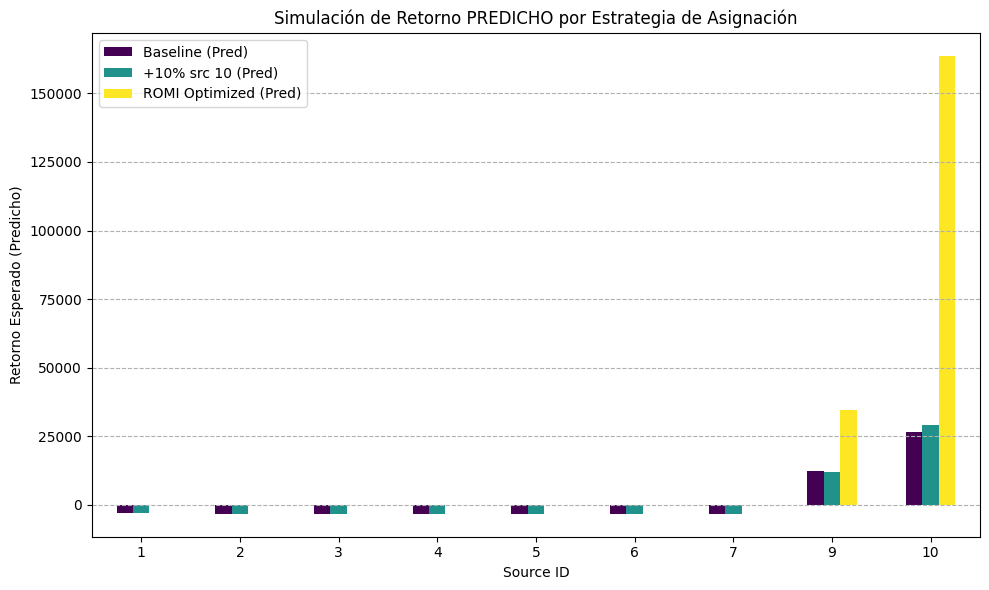


Retornos totales por escenario (predichos):
Baseline (Pred): $15,623.33
+10% src 10 (Pred): $18,078.76
ROMI Optimized (Pred): $198,392.15

Estrategia recomendada basada en predicciones: ROMI Optimized (Pred)
Ganancia estimada vs baseline (predicha): $182,768.82


Asignación de presupuesto recomendada (ROMI Optimized):
   source_id    budget  budget_percentage
0          1      0.00                0.0
1          2      0.00                0.0
2          3      0.00                0.0
3          4      0.00                0.0
4          5      0.00                0.0
5          6      0.00                0.0
6          7      0.00                0.0
7          9   9451.28               31.5
8         10  20548.72               68.5


<Figure size 640x480 with 0 Axes>

In [ ]:
# Generar Predicciones de LTV y CAC 
try:
    df['LTV_180_pred'] = best_ltv_model.predict(X_features)
    df['CAC_source_30_pred'] = best_cac_model.predict(X_features)
    print("Predicciones de LTV y CAC generadas.")
except Exception as e:
    print(f"Error durante la predicción: {e}")
    print("Asegúrate que las features en X_features coincidan con las usadas en el entrenamiento.")

# Calcular ROMI Predicho y Agregar por Fuente 
df['CAC_source_30_pred'] = df['CAC_source_30_pred'].clip(lower=0.01) # Evitar división por cero

# Calcular ROMI predicho por usuario
df['predicted_romi'] = (df['LTV_180_pred'] - df['CAC_source_30_pred']) / df['CAC_source_30_pred']

# Filtrar registros válidos para el análisis de ROMI (con predicciones y source_id)
if 'source_id' not in df.columns:
     print("Error: La columna 'source_id' no se encuentra en el DataFrame. Verifica 02_FeatureEngineering.ipynb")
     valid_romi_df = df[['predicted_romi']].dropna()
     can_group_by_source = False
else:
     valid_romi_df = df[['source_id', 'predicted_romi']].dropna()
     can_group_by_source = True


if can_group_by_source:
    grouped_pred = valid_romi_df.groupby('source_id').agg({
        'predicted_romi': 'mean' # Usamos la media del ROMI predicho por fuente
    }).reset_index()

    # Renombrar para claridad
    grouped_pred.rename(columns={'predicted_romi': 'predicted_romi_avg'}, inplace=True)

    print("\nValores promedio de ROMI PREDICTED por source_id:")
    print(grouped_pred)

    # Simular Escenarios de Asignación de Presupuesto
    total_budget = 30000 # Presupuesto total de marketing
    num_sources = grouped_pred['source_id'].nunique()
    if num_sources == 0:
        print("Error: No se encontraron fuentes para agrupar.")
    else:
        initial_budget_per_source = total_budget / num_sources
        grouped_pred['budget'] = initial_budget_per_source

        # ESCENARIO BASELINE: retorno con asignación igual y ROMI PREDICHO
        grouped_pred['return_baseline'] = grouped_pred['budget'] * grouped_pred['predicted_romi_avg']

        # ESCENARIO 1: +10% presupuesto a UNA fuente (ej. la de mayor ROMI predicho), redistribución proporcional
        # Identificar la fuente con mayor ROMI predicho (o elegir una específica como 'source_id' X)
        source_to_increase = grouped_pred.loc[grouped_pred['predicted_romi_avg'].idxmax(), 'source_id']
        print(f"\nEscenario 1: Aumentando presupuesto para source_id = {source_to_increase}")
        scenario_plus10 = grouped_pred.copy()
        scenario_plus10.loc[scenario_plus10['source_id'] == source_to_increase, 'budget'] *= 1.10
        # Rebalancear para mantener total_budget constante
        scenario_plus10['budget'] = scenario_plus10['budget'] / scenario_plus10['budget'].sum() * total_budget
        # Calcular retorno
        scenario_plus10['return_plus10'] = scenario_plus10['budget'] * scenario_plus10['predicted_romi_avg']

        # ESCENARIO 2: Redistribución proporcional al ROMI PREDICHO
        # Manejar ROMIs negativos/cero para la proporción: Si todos son <= 0, mantener baseline. Si hay positivos, usar solo esos.
        scenario_optimal = grouped_pred.copy()
        positive_romi_sum = scenario_optimal.loc[scenario_optimal['predicted_romi_avg'] > 0, 'predicted_romi_avg'].sum()

        if positive_romi_sum > 0:
            # Asignar proporcionalmente a los que tienen ROMI > 0
            scenario_optimal['budget'] = scenario_optimal.apply(
                lambda row: (row['predicted_romi_avg'] / positive_romi_sum * total_budget) if row['predicted_romi_avg'] > 0 else 0,
                axis=1
            )
            print("\nEscenario 2: Optimizando presupuesto basado en ROMI predicho positivo.")
        else:
            # Si todos los ROMI predichos son <= 0, no optimizar, mantener baseline
            scenario_optimal['budget'] = initial_budget_per_source
            print("\nEscenario 2: Todos los ROMI predichos son <= 0. Manteniendo asignación baseline.")

        scenario_optimal['return_optimal'] = scenario_optimal['budget'] * scenario_optimal['predicted_romi_avg']

        # Visualizar Comparación
        comparison = pd.DataFrame({
            'source_id': grouped_pred['source_id'],
            'Baseline (Pred)': grouped_pred['return_baseline'],
            f'+10% src {source_to_increase} (Pred)': scenario_plus10['return_plus10'],
            'ROMI Optimized (Pred)': scenario_optimal['return_optimal']
        })

        comparison.set_index('source_id').plot(kind='bar', figsize=(10, 6), colormap='viridis')
        plt.title("Simulación de Retorno PREDICHO por Estrategia de Asignación")
        plt.ylabel("Retorno Esperado (Predicho)")
        plt.xlabel("Source ID")
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()
        plt.savefig("../reports/figures/simulacion.png")

        # Mostrar Recomendación
        # Comparar los retornos TOTALES de cada escenario
        total_returns = {
            'Baseline (Pred)': comparison['Baseline (Pred)'].sum(),
            f'+10% src {source_to_increase} (Pred)': comparison[f'+10% src {source_to_increase} (Pred)'].sum(),
            'ROMI Optimized (Pred)': comparison['ROMI Optimized (Pred)'].sum()
        }
        best_strategy = max(total_returns, key=total_returns.get)
        gain_vs_baseline = total_returns[best_strategy] - total_returns['Baseline (Pred)']

        print("\nRetornos totales por escenario (predichos):")
        for strategy, ret in total_returns.items():
            print(f"{strategy}: ${ret:,.2f}")

        print(f"\nEstrategia recomendada basada en predicciones: {best_strategy}")
        print(f"Ganancia estimada vs baseline (predicha): ${gain_vs_baseline:,.2f}\n")

        # Mostrar la asignación de presupuesto recomendada para la estrategia óptima
        if best_strategy == 'ROMI Optimized (Pred)':
            print("\nAsignación de presupuesto recomendada (ROMI Optimized):")
            optimal_allocation = scenario_optimal[['source_id', 'budget']].copy()
            optimal_allocation['budget_percentage'] = (optimal_allocation['budget'] / total_budget) * 100
            print(optimal_allocation.round(2))

else: # Si no se pudo agrupar por fuente
    print("\nNo se pudo agrupar por 'source_id'. Mostrando ROMI predicho promedio general.")
    print(f"ROMI promedio predicho para todos los usuarios: {valid_romi_df['predicted_romi'].mean():.4f}")
    print("No se pueden realizar simulaciones por fuente.")